# Speech Emotion Recognition

### Extracting the data

In [1]:
import os

DATA_DIR = "dataset/"

files = []
for filename in os.listdir(DATA_DIR):
    for audio_file in os.listdir(DATA_DIR + filename):
        files.append(filename + "/" + audio_file)

print(len(files))


1440


In [2]:
# extracting the class labels i.e the emotion
labels = []
for filename in files:
    emotion = filename.split('/')[1].split('.')[0].split('-')[2]
    labels.append(emotion)

print(len(labels))

1440


In [3]:
class_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

num_class_map = {
    'neutral': 0,
    'calm': 1,
    'happy': 2,
    'sad': 3,
    'angry': 4,
    'fearful': 5,
    'disgust': 6,
    'surprised': 7
}

In [4]:
new_labels = [num_class_map[class_map[label]] for label in labels]

In [5]:
import pandas as pd

dataframe = dict(zip(files, new_labels))
df = pd.DataFrame(list(dataframe.items()), columns=['filename', 'emotion'])
df.head()


,filename,emotion
0,Actor_05/03-01-07-02-02-01-05.wav,6
1,Actor_05/03-01-05-02-01-01-05.wav,4
2,Actor_05/03-01-04-02-02-02-05.wav,3
3,Actor_05/03-01-04-01-02-01-05.wav,3
4,Actor_05/03-01-06-02-01-01-05.wav,5


## MFCCs

In [6]:
path = df.loc[0, 'filename']
path

'Actor_05/03-01-07-02-02-01-05.wav'

In [7]:
import librosa
import numpy as np

In [8]:
# loading an example audio file
data, sampling_rate = librosa.load(DATA_DIR + df.loc[10, 'filename'], sr=22050*2, duration=5, offset=0.5)

# calculating mfcc of the audio file
mfccs = librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=40)

In [9]:
import IPython.display as ipd  
import matplotlib.pyplot as plt

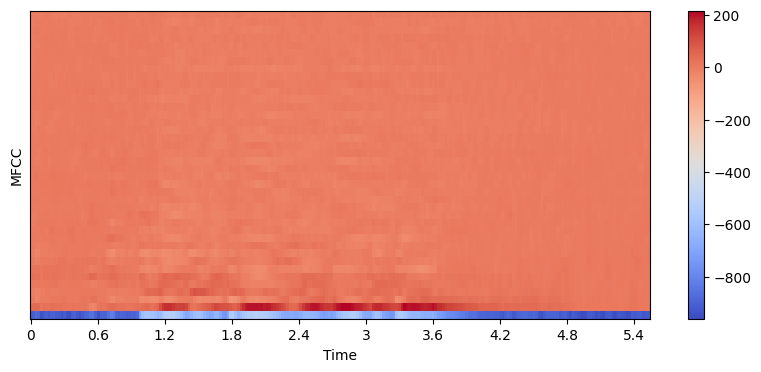

In [10]:
# plotting the mfcc
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.ylabel('MFCC')

ipd.Audio(DATA_DIR + df.loc[0, 'filename'])


### Using this as our data format, we create a dataset for training a 2-dimensional CNN.

In [11]:
df1 = pd.DataFrame()
df1['file_path'] = DATA_DIR + df['filename']
df1['emotion'] = df['emotion']
df1.head()

,file_path,emotion
0,dataset/Actor_05/03-01-07-02-02-01-05.wav,6
1,dataset/Actor_05/03-01-05-02-01-01-05.wav,4
2,dataset/Actor_05/03-01-04-02-02-02-05.wav,3
3,dataset/Actor_05/03-01-04-01-02-01-05.wav,3
4,dataset/Actor_05/03-01-06-02-01-01-05.wav,5


In [12]:

# loop feature extraction over the entire dataset
features = []
for index,path in enumerate(df1['file_path']):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
    sample_rate = np.array(sample_rate)
    mfccs = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
    features.append(mfccs)

In [13]:
# filtering out irregular shaped mfccs

indices = [i for i, mfcc in enumerate(features) if mfcc.shape[1] == 216]
features = [mfcc for mfcc in features if mfcc.shape[1] == 216]
emotions = df1['emotion'][indices]
features = np.array(features)
print(features.shape)
print(len(emotions))

(1438, 13, 216)
1438


In [14]:
# splitting the data into training and testing
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, emotions, test_size=0.2, random_state=1)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(1150, 13, 216) (288, 13, 216) (1150,) (288,)


In [15]:
# standardize the data

mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

In [16]:
# converting the data to numpy array
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [17]:
# converting the data to tensor
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).long()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).long()


In [18]:
# adding an extra dimension so the data can be fed into a 2-D CNN
X_train = X_train.reshape(X_train.shape[0], 1, 13, 216)
X_test = X_test.reshape(X_test.shape[0], 1, 13, 216)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

torch.Size([1150, 1, 13, 216]) torch.Size([288, 1, 13, 216]) torch.Size([1150]) torch.Size([288])


In [19]:
# using the GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [20]:
# building the model

class CNN(nn.Module):
    def __init__(self):
            super().__init__()
            self.network = nn.Sequential(
                
                nn.Conv2d(1, 32, kernel_size = 3, padding = 1),
                nn.ReLU(),
                nn.MaxPool2d(2,2),
                nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
                nn.ReLU(),
                nn.MaxPool2d(2,2),
                nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
                nn.ReLU(),
                nn.MaxPool2d(2,2),
                
                nn.Flatten(),
                nn.Linear(3456,1024),
                nn.ReLU(),
                nn.Linear(1024, 512),
                nn.ReLU(),
                nn.Linear(512, 8)
            )
        
    def forward(self, x):
        return self.network(x)
    
model = CNN()
model = model.to(device)
print(model)

CNN(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=3456, out_features=1024, bias=True)
    (11): ReLU()
    (12): Linear(in_features=1024, out_features=512, bias=True)
    (13): ReLU()
    (14): Linear(in_features=512, out_features=8, bias=True)
  )
)


In [21]:
# model training

from tqdm import tqdm

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 70
batch_size = 32

train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(dataset=train_data, batch_size=batch_size)

/home/shail/Projects/Speech_emotion_recognition/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
for e in range(epochs):
    running_loss = 0
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    else:
        print(f"Epoch [{e+1}] training loss: {running_loss/len(train_loader)}")


  0%|          | 0/36 [00:00<?, ?it/s]/home/shail/Projects/Speech_emotion_recognition/env/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 36/36 [00:00<00:00, 96.19it/s]


Epoch [1] training loss: 1.9338687128490872


100%|██████████| 36/36 [00:00<00:00, 220.95it/s]


Epoch [2] training loss: 1.5977817078431447


100%|██████████| 36/36 [00:00<00:00, 216.28it/s]


Epoch [3] training loss: 1.3901608950561948


100%|██████████| 36/36 [00:00<00:00, 206.87it/s]


Epoch [4] training loss: 1.1587522940503225


100%|██████████| 36/36 [00:00<00:00, 203.44it/s]


Epoch [5] training loss: 0.9162908378574584


100%|██████████| 36/36 [00:00<00:00, 190.82it/s]


Epoch [6] training loss: 0.6972046602103446


100%|██████████| 36/36 [00:00<00:00, 197.87it/s]


Epoch [7] training loss: 0.5192142170336511


100%|██████████| 36/36 [00:00<00:00, 197.95it/s]


Epoch [8] training loss: 0.4193725014726321


100%|██████████| 36/36 [00:00<00:00, 202.28it/s]


Epoch [9] training loss: 0.24862117175426748


100%|██████████| 36/36 [00:00<00:00, 207.80it/s]


Epoch [10] training loss: 0.1271259500645101


100%|██████████| 36/36 [00:00<00:00, 214.09it/s]


Epoch [11] training loss: 0.08658129424374136


100%|██████████| 36/36 [00:00<00:00, 210.00it/s]


Epoch [12] training loss: 0.08615776053112414


100%|██████████| 36/36 [00:00<00:00, 217.47it/s]


Epoch [13] training loss: 0.0899248793721199


100%|██████████| 36/36 [00:00<00:00, 199.03it/s]


Epoch [14] training loss: 0.14450306238399613


100%|██████████| 36/36 [00:00<00:00, 201.01it/s]


Epoch [15] training loss: 0.07051448827971601


100%|██████████| 36/36 [00:00<00:00, 189.17it/s]


Epoch [16] training loss: 0.031215396932869528


100%|██████████| 36/36 [00:00<00:00, 186.60it/s]


Epoch [17] training loss: 0.016678935953273646


100%|██████████| 36/36 [00:00<00:00, 205.60it/s]


Epoch [18] training loss: 0.012906431208345262


100%|██████████| 36/36 [00:00<00:00, 213.08it/s]


Epoch [19] training loss: 0.004123404062637646


100%|██████████| 36/36 [00:00<00:00, 210.88it/s]


Epoch [20] training loss: 0.001392876432469671


100%|██████████| 36/36 [00:00<00:00, 212.25it/s]


Epoch [21] training loss: 0.0002964471002794906


100%|██████████| 36/36 [00:00<00:00, 198.68it/s]


Epoch [22] training loss: 0.0002074672540604499


100%|██████████| 36/36 [00:00<00:00, 198.71it/s]


Epoch [23] training loss: 0.00015983749957134327


100%|██████████| 36/36 [00:00<00:00, 198.00it/s]


Epoch [24] training loss: 0.0001291532146044321


100%|██████████| 36/36 [00:00<00:00, 200.52it/s]


Epoch [25] training loss: 0.00010675714889253464


100%|██████████| 36/36 [00:00<00:00, 207.95it/s]


Epoch [26] training loss: 8.96218160354086e-05


100%|██████████| 36/36 [00:00<00:00, 213.69it/s]


Epoch [27] training loss: 7.614954837562336e-05


100%|██████████| 36/36 [00:00<00:00, 214.33it/s]


Epoch [28] training loss: 6.512488180811083e-05


100%|██████████| 36/36 [00:00<00:00, 213.64it/s]


Epoch [29] training loss: 5.6031040685411426e-05


100%|██████████| 36/36 [00:00<00:00, 181.84it/s]


Epoch [30] training loss: 4.865950796152497e-05


100%|██████████| 36/36 [00:00<00:00, 197.18it/s]


Epoch [31] training loss: 4.281670127663043e-05


100%|██████████| 36/36 [00:00<00:00, 197.79it/s]


Epoch [32] training loss: 3.801693392486211e-05


100%|██████████| 36/36 [00:00<00:00, 200.89it/s]


Epoch [33] training loss: 3.355839961235082e-05


100%|██████████| 36/36 [00:00<00:00, 205.58it/s]


Epoch [34] training loss: 2.9873637294662734e-05


100%|██████████| 36/36 [00:00<00:00, 213.82it/s]


Epoch [35] training loss: 2.6653109898688854e-05


100%|██████████| 36/36 [00:00<00:00, 210.12it/s]


Epoch [36] training loss: 2.386999389929972e-05


100%|██████████| 36/36 [00:00<00:00, 206.35it/s]


Epoch [37] training loss: 2.147468175432247e-05


100%|██████████| 36/36 [00:00<00:00, 200.18it/s]


Epoch [38] training loss: 1.939911708682808e-05


100%|██████████| 36/36 [00:00<00:00, 202.34it/s]


Epoch [39] training loss: 1.755633064703943e-05


100%|██████████| 36/36 [00:00<00:00, 200.93it/s]


Epoch [40] training loss: 1.5920167104215783e-05


100%|██████████| 36/36 [00:00<00:00, 198.77it/s]


Epoch [41] training loss: 1.4510079065783228e-05


100%|██████████| 36/36 [00:00<00:00, 217.00it/s]


Epoch [42] training loss: 1.3259319151378198e-05


100%|██████████| 36/36 [00:00<00:00, 214.73it/s]


Epoch [43] training loss: 1.2143367952275083e-05


100%|██████████| 36/36 [00:00<00:00, 217.70it/s]


Epoch [44] training loss: 1.1149517793758909e-05


100%|██████████| 36/36 [00:00<00:00, 176.93it/s]


Epoch [45] training loss: 1.026362956066704e-05


100%|██████████| 36/36 [00:00<00:00, 203.27it/s]


Epoch [46] training loss: 9.45144274232411e-06


100%|██████████| 36/36 [00:00<00:00, 193.40it/s]


Epoch [47] training loss: 8.72746434449962e-06


100%|██████████| 36/36 [00:00<00:00, 200.28it/s]


Epoch [48] training loss: 8.072623791753762e-06


100%|██████████| 36/36 [00:00<00:00, 205.89it/s]


Epoch [49] training loss: 7.478794840507261e-06


100%|██████████| 36/36 [00:00<00:00, 207.53it/s]


Epoch [50] training loss: 6.940688131685925e-06


100%|██████████| 36/36 [00:00<00:00, 208.05it/s]


Epoch [51] training loss: 6.451818882800984e-06


100%|██████████| 36/36 [00:00<00:00, 213.34it/s]


Epoch [52] training loss: 6.008436145066298e-06


100%|██████████| 36/36 [00:00<00:00, 196.59it/s]


Epoch [53] training loss: 5.606675772342997e-06


100%|██████████| 36/36 [00:00<00:00, 201.99it/s]


Epoch [54] training loss: 5.237061271954089e-06


100%|██████████| 36/36 [00:00<00:00, 200.75it/s]


Epoch [55] training loss: 4.90269606877468e-06


100%|██████████| 36/36 [00:00<00:00, 198.88it/s]


Epoch [56] training loss: 4.587907947476803e-06


100%|██████████| 36/36 [00:00<00:00, 204.55it/s]


Epoch [57] training loss: 4.304493125396726e-06


100%|██████████| 36/36 [00:00<00:00, 204.72it/s]


Epoch [58] training loss: 4.039841463231318e-06


100%|██████████| 36/36 [00:00<00:00, 204.92it/s]


Epoch [59] training loss: 3.797057170610666e-06


100%|██████████| 36/36 [00:00<00:00, 217.82it/s]


Epoch [60] training loss: 3.575933792237467e-06


100%|██████████| 36/36 [00:00<00:00, 200.79it/s]


Epoch [61] training loss: 3.3714765900564694e-06


100%|██████████| 36/36 [00:00<00:00, 198.04it/s]


Epoch [62] training loss: 3.185141363499295e-06


100%|██████████| 36/36 [00:00<00:00, 198.68it/s]


Epoch [63] training loss: 3.0100091221483026e-06


100%|██████████| 36/36 [00:00<00:00, 198.26it/s]


Epoch [64] training loss: 2.845955582605105e-06


100%|██████████| 36/36 [00:00<00:00, 211.19it/s]


Epoch [65] training loss: 2.6937535453599694e-06


100%|██████████| 36/36 [00:00<00:00, 212.21it/s]


Epoch [66] training loss: 2.5526234905568244e-06


100%|██████████| 36/36 [00:00<00:00, 210.42it/s]


Epoch [67] training loss: 2.420971763999407e-06


100%|██████████| 36/36 [00:00<00:00, 213.41it/s]


Epoch [68] training loss: 2.3010612919291716e-06


100%|██████████| 36/36 [00:00<00:00, 199.74it/s]


Epoch [69] training loss: 2.1880974440730624e-06


100%|██████████| 36/36 [00:00<00:00, 198.88it/s]

Epoch [70] training loss: 2.0826047107094482e-06


In [23]:
# testing the model

test_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size)

model.eval()

with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f"Test accuracy: {100*correct/total}%")

Test accuracy: 68.75%


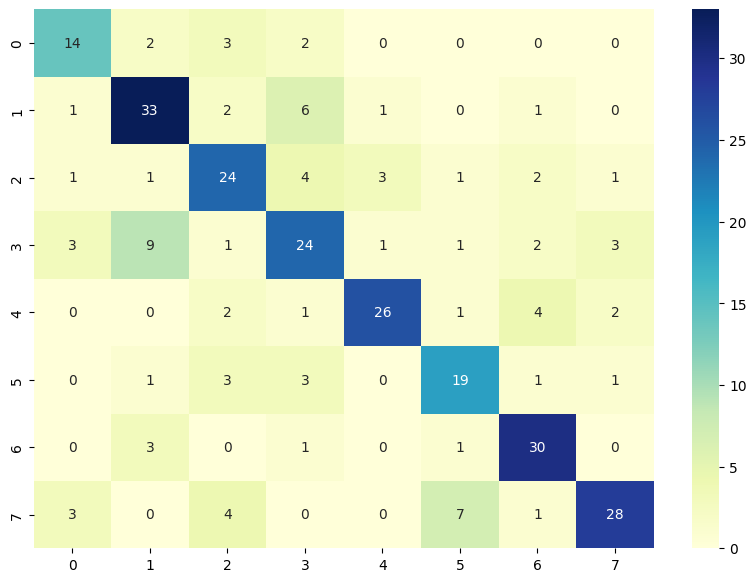

In [24]:
# confusion matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

y_pred = []
y_true = []

with torch.no_grad():
    model.eval()
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm, index = [i for i in range(8)], columns = [i for i in range(8)])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, cmap="YlGnBu")
plt.show()


In [25]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.67      0.65        21
           1       0.67      0.75      0.71        44
           2       0.62      0.65      0.63        37
           3       0.59      0.55      0.56        44
           4       0.84      0.72      0.78        36
           5       0.63      0.68      0.66        28
           6       0.73      0.86      0.79        35
           7       0.80      0.65      0.72        43

    accuracy                           0.69       288
   macro avg       0.69      0.69      0.69       288
weighted avg       0.69      0.69      0.69       288



## We achieve an accuracy of 70% from training a CNN on the MFCCs of the audio.